# Numerické integrování


## Integrace
Vypočteme integrál funkce `4/(1+x**2)` na intervalu `[0,1]` obdélníkovou metodou s dělením na 100 intervalů, $n=100$:
$$ s
I^{\rm OP} = \sum_{i=0}^{n-1} f(x_i)h
$$
$$
x_i = a + ih;\quad h=\frac{b-a}{n}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def quad_rectangle(f, a, b, N, pos=0.):
    # ukol 3
    dx = (b-a)/N
    x = a + (pos + np.arange(N))*dx
    return np.sum(f(x)*dx)

In [3]:
def f(x): return 4/(1+x**2)

In [4]:
Ns = 2**np.arange(10)
ints = np.array([quad_rectangle(f, 0, 1, N) for N in Ns])
ints2 = np.array([quad_rectangle(f, 0, 1, N, pos=0.5) for N in Ns])

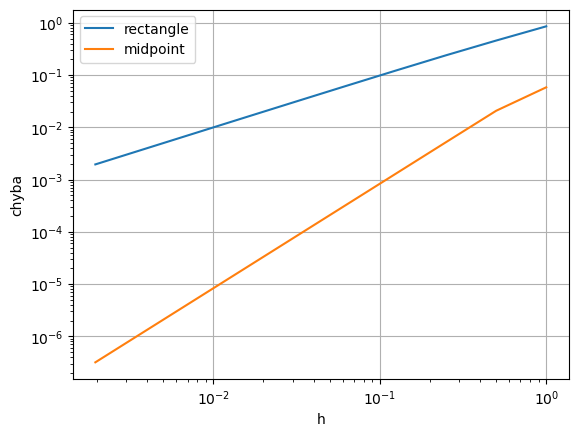

In [5]:
plt.loglog(1./Ns, np.abs(ints-np.pi), label="rectangle")
plt.loglog(1./Ns, np.abs(ints2-np.pi), label="midpoint")
plt.grid()
plt.legend()
plt.xlabel("h")
plt.ylabel("chyba")
plt.show()

Optimální volba je $\xi=0.5$, dostáváme tak "midpoint rule" druhého řádu přesnosti

### Chyba lichoběžníkového pravidla
Využijeme sympy použít pro rozbor chyb integrace. Vypočteme aproximaci integrálu lichoběžníkovým pravidlem. Rozvoj provádíme ze středu intervalu.

In [6]:
from sympy import *
x, y, z, t = symbols('x y z t')
_f = symbols('f', cls=Function)
h, u = symbols("h u")

In [7]:
series = _f(t).series(t, y, 8)
Ihat = h/2*(series.subs(t, y+h/2) + series.subs(t, y-h/2))
Ihat.expand()

h*f(y) + h**3*Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, y)/8 + h**5*Subs(Derivative(f(_xi_1), (_xi_1, 4)), _xi_1, y)/384 + h**7*Subs(Derivative(f(_xi_1), (_xi_1, 6)), _xi_1, y)/46080 + O(h**9)

Dále analyticky vypočteme integrál rozvoje

In [8]:
I = integrate(series.subs(t, y+u), (u, -h/2, +h/2))
I

h*f(y) + h**3*Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, y)/24 + h**5*Subs(Derivative(f(_xi_1), (_xi_1, 4)), _xi_1, y)/1920 + h**7*Subs(Derivative(f(_xi_1), (_xi_1, 6)), _xi_1, y)/322560 + O(h**9)

a obě hodnoty porovnáme

In [9]:
(Ihat - I).expand()

h**3*Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, y)/12 + h**5*Subs(Derivative(f(_xi_1), (_xi_1, 4)), _xi_1, y)/480 + h**7*Subs(Derivative(f(_xi_1), (_xi_1, 6)), _xi_1, y)/53760 + O(h**9)

a vidíme, že lokální chyba je $o(h^3)$

### Richardsonova extrapolace
Řekněme, že hledaný integrál $I$ aproximujeme numericky vypočítanou hodnotou $\hat I(h)$ s chybou $E(h)$:
$$\hat I(h)  = I + E(h).$$

Pokud lze chybu metody $E$ vyjádřit jako polynom v závislosti na velikosti integračního kroku
$$
E = A_1h^{p_1} + A_2h^{p_2} + A_3h^{p_3} + \ldots,
$$
můžeme eliminovat dominantní člen rozvoje
$$
\hat I^{(1)} = \frac{2^{p_1} \hat I(h) - \hat I(2h)}{2^{p_1} - 1} = I + A'_2h^{p_2} + A'_3h^{p_3} + \ldots
$$


Vypočteme integrál z předchozí úlohy lichoběžníkovou metodou s dělením na 10 a 5 intervalů. Využijeme tyto aproximace k redukci chyby Richardsonovou metodou.

In [10]:
def quad_trapezoid(f, a, b, N):
    dx = (b-a)/N
    x = a + np.arange(1, N)*dx
    return 0.5*dx*(f(a) + f(b)) + np.sum(f(x)*dx)

In [11]:
N = 10

In [12]:
print(quad_trapezoid(f, 0, 1, N//2)-np.pi)
print(quad_trapezoid(f, 0, 1, N)-np.pi)


-0.006666539778803049
-0.0016666646826335452


In [13]:
def richardson(f, N0, p):
    # ukol 5
    return (2**p * f(N0) - f(N0//2))/(2**p - 1)

In [14]:
def q(N):
    return quad_trapezoid(f, 0, 1, N)
richardson(q, 10, 2) - np.pi

-3.9650577488004046e-08

In [15]:
# alternativne muzeme definovat tzv. lambda funkci inline
richardson(lambda N:quad_trapezoid(f, 0, 1, N), 10, 2) - np.pi

-3.9650577488004046e-08

### Rombergova integrace
Opakovanou aplikací Richardsonovy extrapolace lze postupně eliminovat další členy chybového rozvoje. Pokud použijeme lichoběžníkovou metodu k výpočtu integrálu s dělením na $2^N$ intervalů, můžeme extrapolovat $N$-krát, čímž dostaneme metodou řádu $2(N+1)$.

In [16]:
def romberg(f, a, b, N, debug=False):
    dx = (b-a)
    a = [0.5*dx*(f(a) + f(b))]
    for i in range(1, N):
        dx *= 0.5
        x = (np.arange(0, 2**(i), 2) + 1)*dx
        a.append(a[-1]*0.5 + np.sum(f(x))*dx)

    b = [np.array(a)]
    for j in range(1, N):
        b.append((2**(2*j) * b[-1][1:] - b[-1][:-1])/(2**(2*j) - 1))
    
    if debug:
        for i, l in enumerate(b):
            print("%d. order estimates:"%(2*(i+1)), l-np.pi)
    return b[-1][0]

In [17]:
romberg(f, 0, 1, 5, debug=True)

2. order estimates: [-0.14159265 -0.04159265 -0.01041618 -0.00260416 -0.00065104]
4. order estimates: [-8.25932026e-03 -2.40261388e-05 -1.51131086e-07 -2.36497089e-09]
6. order estimates: [5.24993469e-04 1.44053610e-06 7.55276997e-09]
8. order estimates: [-6.86982792e-06 -1.51929971e-08]
10. order estimates: [1.1687924e-08]


3.141592665277717

In [18]:
N = np.arange(1, 25)
I = np.array([romberg(f, 0, 1, n) for n in N])
I_trapezoid = np.array([quad_trapezoid(f, 0, 1, 2**(n-1)) for n in N])
h = 1/2**(N)

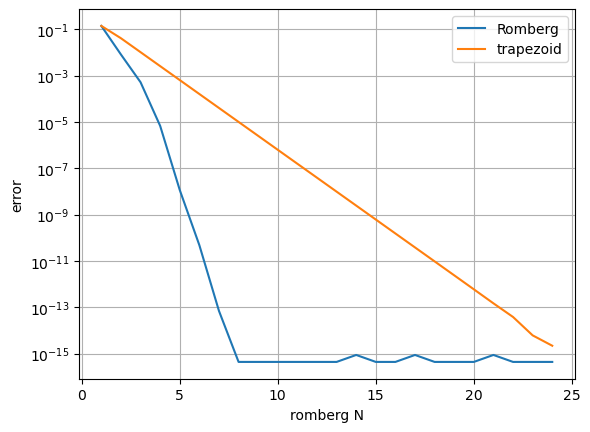

In [19]:
plt.semilogy(N, np.abs(I-np.pi), label="Romberg")
plt.semilogy(N, np.abs(I_trapezoid-np.pi), label="trapezoid")
plt.legend()
plt.ylabel("error")
plt.xlabel("romberg N")
plt.grid()
plt.show()

In [20]:
romberg(f, 0, 1, 9)

3.1415926535897936

In [21]:
np.pi

3.141592653589793

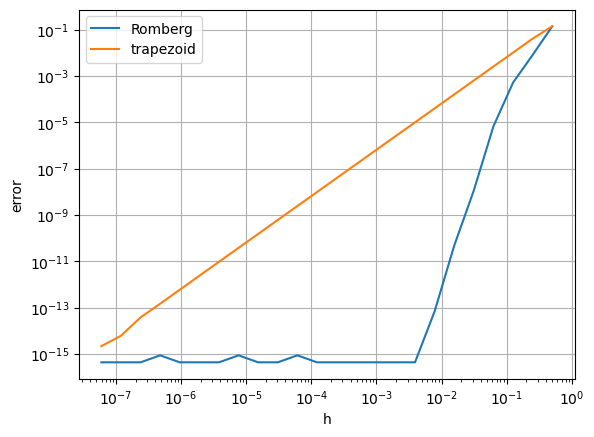

In [22]:
plt.plot(h, np.abs(I-np.pi), label="Romberg")
plt.plot(h, np.abs(I_trapezoid-np.pi), label="trapezoid")
plt.legend()
plt.ylabel("error")
plt.xlabel("h")
plt.grid()
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [23]:
import numpy as np
from math import fsum

In [24]:
# naivni sumace
def simplesum(input):
    summ  = 0
    for num in input:
        summ += num
    return summ

In [25]:
# kahanova sumace
def kahansum(input):
    summ = c = 0
    for num in input:
        y = num - c         # c je chyba z minule iterace
        t = summ + y        # nova aproximace sumy
        c = (t - summ) - y  # vypocet chyby
        summ = t
    return summ

### Example 1

In [26]:
data = np.ones(10**7)*1e-7
data

array([1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07])

In [27]:
simplesum(data)-1

-2.4983004554002264e-10

In [28]:
kahansum(data)-1

0.0

In [29]:
np.sum(data)-1

1.7319479184152442e-14

In [30]:
sum(data)-1

-2.4983004554002264e-10

### Example 2

In [31]:
data2 = np.array([1e15, np.pi, -1e15, -np.pi])

In [32]:
simplesum(data2)

-0.016592653589793116

In [33]:
kahansum(data2)

-0.016592653589793116

In [34]:
np.sum(data2)

-0.016592653589793116

In [35]:
fsum(data2)

0.0

In [36]:
# Neumaierova sumace https://en.wikipedia.org/wiki/Kahan_summation_algorithm#Further_enhancements
def nmsum(input):
    summ = 0.0
    c = 0.0                 # A running compensation for lost low-order bits.
    for num in input:
        t = summ + num
        if abs(summ) >= abs(num):
            c += (summ - t) + num # If sum is bigger, low-order digits of input[i] are lost.
        else:
            c += (num - t) + summ # Else low-order digits of sum are lost
        summ = t
    return summ + c               # Correction only applied once in the very end

In [37]:
nmsum(data2)

0.0